#### FINDING COMMUNITIES

In [17]:
%%time
def plot_communities(pat, data_type, data, algo, anno_db, wordcloud_display, save_fig):
    
    seed = 42
    # dtype_title = _DTYPE_TITLES[_NET_TYPES.index(data_type)]
    # data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data)]
    
    try:
        G = grnboost2_meta[pat][data][f'graph_{data_type}']
    except KeyError:
        G = get_nx_graph(data, data_type, pat=pat, get_filtered=_Q_THRESH)
        
    print(f'The chosen graph for pat={colored(pat, "red")}, data={colored(data, "red")}, data_type={colored(data_type, "red")}:')
    print(f'Number of nodes: {colored(G.number_of_nodes(), "cyan")}; Number of edges: {colored(G.number_of_edges(), "cyan")}')
        
    if algo == 'louvain':
        partition = community_louvain.best_partition(G.to_undirected(), weight='importance', random_state=seed)
    else:
        G_igraph = ig.Graph.from_networkx(G.to_undirected())\b
        la_partition = la.find_partition(G_igraph, la.ModularityVertexPartition, weights='importance', seed=seed)
        partition = {G_igraph.vs[node]['_nx_name']: i for i, cluster_nodes in enumerate(la_partition) for node in cluster_nodes}

    num_partitions = len(set(partition.values()))
    print(f'Number of partitions using {algo} algorithm: {colored(num_partitions, "cyan")}')
        
    f, ax = plt.subplots(figsize=(25, 45))
    cmap = ListedColormap(sns.color_palette(cc.glasbey_bw, n_colors=num_partitions).as_hex())
    
    # Getting positions of squeezed graph
    squeezed_G, squeezed_partition = squeeze_graph(G, partition)
    print('Computed a squeezed graph representation..')
    
    squeezed_pos = netgraph_community_layout(squeezed_G, squeezed_partition, seed=seed)  # nx.nx_agraph.pygraphviz_layout(G.to_undirected(), prog="sfdp")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    print('Computed node positions of the squeezed graph representation..')
    plot_cloud(G, partition, squeezed_pos, ax=ax, anno_db=anno_db, 
               filter_genes=True, limit_anno_until=50, 
               display_func=True if wordcloud_display == 'funcs' else False)
    print('Finished plotting a word cloud..')
    nx.draw(squeezed_G, squeezed_pos, ax=ax, arrowstyle="->", arrowsize=20, connectionstyle=f'arc3, rad = 0.25', edge_color='k', width=0.4, node_color='k', node_size=50, alpha=0.01)
    nx.draw_networkx_nodes(squeezed_G, squeezed_pos, ax=ax, node_size=100, nodelist=list(squeezed_partition.keys()), node_color=list(squeezed_partition.values()), cmap=cmap, alpha=0.01)
    print('Finished plotting gene nodes..')
    ax.set_title(f'Found communities ({pat}, {data_type}, {data})', fontsize=30)
    
    plt.axis('off')
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f"{pat}_{data}_{data_type}_communities_{wordcloud_display}.png"), bbox_inches='tight', dpi=400)
    
def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list(dtype_dropdown.value, pat_dropdown.value)]
      
dtype_dropdown = Dropdown(description='Data type:', options=_NET_TYPES)
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_TYPES else ''}", p) for p in _AVAIL_Gs['all'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('all', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
dtype_dropdown.observe(pick_pat_dtypes, names='value')
        
widget = interactive(
    plot_communities, 
    {'manual': True},
    pat=pat_dropdown, 
    data_type=dtype_dropdown, 
    data=data_dropdown,
    algo=['leiden', 'louvain'],
    anno_db=['GO', 'hallmark', 'KEGG', 'immunological'],
    wordcloud_display=['funcs', 'genes'],
    save_fig=[False, True]
)
display(widget)

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

CPU times: user 381 ms, sys: 101 ms, total: 482 ms
Wall time: 999 ms


#### COMMUNITY ANALYSIS

##### General stats

In [27]:
def community_ana_agg(data, db, save_fig):
    
    import textwrap
    
    top_n = 10
    seed = 42
    sns.set_style("whitegrid")
    n_bins = 100
    algo = 'leiden'
    len_wrap = 100
    
    wrap_text = lambda x: '\n    '.join(textwrap.wrap(x, width=len_wrap))
        
    # Loading data
    data_folder = 'all_data' if data == 'raw_data' else data.replace('raw_data_', '')

    data_to = os.path.join(_DATA_HOME, 'cell_types', data_folder, 'data', 'grnboost2', f'{algo}_communities')
        
    data_all = pd.read_pickle(os.path.join(data_to, f'raw_data_communities_info.pickle'))
    data_C, data_M, data_S = [
        pd.read_pickle(os.path.join(data_to, f'raw_data_{pat}_type_communities_info.pickle')) for pat in ['C', 'M', 'S']
    ]
    
    print(f'STATS FOR {data.upper()}')
    print()
    for curr_type in ['all', 'C', 'M', 'S']:
        curr = eval(f'data_{curr_type}')
        print(f'Overall the {colored(annotate_option(curr_type, data) + f" {curr_type}", "cyan")} contains {colored(str(len(curr)), "cyan")} clusters..')
        print('The number of nodes and edges in each cluster:')
        display(pd.DataFrame(curr[['num_nodes', 'num_edges']]).T.assign(sum=curr[['num_nodes', 'num_edges']].sum()))
    print()
    print(colored(f'Top {top_n} main functions according to {db}:', 'cyan'))
    for i in range(len(data_all)):
        print(wrap_text(f'{colored(i, "cyan")} --> ' + ' '.join(
            re.findall(r'>>>.*?<<<', data_all.loc[i, f'main_functions_{db}'])[:top_n]
        ).replace('>>', '').replace('<<', '')))
    print()
        
    print(colored(f'Top {top_n} main genes:', 'cyan'))
    doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
    print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    for i in range(len(data_all)):
        top_genes = list(map(lambda x: x[:x.find(' ')], data_all['sorted_central_genes_scores'][i].split('; ')))[:top_n]
        top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], data_all['sorted_central_genes_scores'][i].split('; ')))[:top_n]
        out = f'{colored(i, "cyan")} --> '
        for g, s in zip(top_genes, top_scores):
            if g in lambert_TF_names and g in dorothea_TF_names:
                out += f'{colored(g, both_c)} ({s}), '
            elif g not in lambert_TF_names and g in dorothea_TF_names:
                out += f'{colored(g, doro_c)} ({s}), '
            elif g in lambert_TF_names and g not in dorothea_TF_names:
                out += f'{colored(g, lamb_c)} ({s}), '
            else:
                out += f'{g} ({s}), '
        print(wrap_text(out[:-2]))
    print()
    
    print(colored(f'Top {top_n} newly-discovered gene-gene link using KEGG', 'cyan'))
    norm_c, doro_c, lamb_c, both_c = 'yellow', 'green', 'red', 'magenta'
    print(f"{colored('Regular', norm_c)}, {colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    for i in range(len(data_all)):
        top_links = [
            (l[:l.find(' ')], l[l.find('>') + 1:l.rfind('(') - 1]) \
                for k, l in enumerate(data_all['new_gene_gene_links_KEGG'][i].split('; ')) if k < top_n
        ]
        top_annos = [
            (l[l.find('('): l.find(')') + 1], l[l.rfind('('): l.rfind(')') + 1]) \
                for l in data_all['new_gene_gene_links_KEGG'][i].split('; ')
        ]
        out = f'{colored(i, "cyan")} --> '
        for l, a in zip(top_links, top_annos):
            if l[0] in lambert_TF_names and l[0] in dorothea_TF_names:
                out += f'{colored(l[0], both_c)} {a[0]} '
            elif l[0] not in lambert_TF_names and l[0] in dorothea_TF_names:
                out += f'{colored(l[0], doro_c)} {a[0]} '
            elif l[0] in lambert_TF_names and l[0] not in dorothea_TF_names:
                out += f'{colored(l[0], lamb_c)} {a[0]} '
            else:
                out += f'{colored(l[0], norm_c)} {a[0]} '
                
            out += '<-> '
            
            if l[1] in lambert_TF_names and l[1] in dorothea_TF_names:
                out += f'{colored(l[1], both_c)} {a[1]} '
            elif l[1] not in lambert_TF_names and l[1] in dorothea_TF_names:
                out += f'{colored(l[1], doro_c)} {a[1]} '
            elif l[1] in lambert_TF_names and l[1] not in dorothea_TF_names:
                out += f'{colored(l[1], lamb_c)} {a[1]} '
            else:
                out += f'{colored(l[1], norm_c)} {a[1]} '
        print(wrap_text(out[:-1]))
    print()
    print()
        
    for pat in ['C', 'M', 'S']:
        curr_d = eval(f'data_{pat}')
        #print(colored(f'Top {top_n} main functions according to {db}:', 'cyan'))
        #for i in range(len(curr_d)):
        #    print(f'{colored(i, "cyan")} --> ' + ' '.join(
        #        re.findall(r'>>>.*?<<<', curr_d.loc[i, f'main_functions_{db}'])[:top_n]
        #    ).replace('>>', '').replace('<<', ''))
        # 
        print(f"{colored(f'Top {top_n} main genes for type:', 'cyan')} {colored(pat, 'red')}")
        doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
        print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
        for i in range(len(curr_d)):
            top_genes = list(map(lambda x: x[:x.find(' ')], curr_d['sorted_central_genes_scores'][i].split('; ')))[:top_n]
            top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], curr_d['sorted_central_genes_scores'][i].split('; ')))[:top_n]
            out = f'{colored(i, "cyan")} --> '
            for g, s in zip(top_genes, top_scores):
                if g in lambert_TF_names and g in dorothea_TF_names:
                    out += f'{colored(g, both_c)} ({s}), '
                elif g not in lambert_TF_names and g in dorothea_TF_names:
                    out += f'{colored(g, doro_c)} ({s}), '
                elif g in lambert_TF_names and g not in dorothea_TF_names:
                    out += f'{colored(g, lamb_c)} ({s}), '
                else:
                    out += f'{g} ({s}), '
            print(wrap_text(out[:-2]))
            
    print()
    print()
    print(colored(f'Top {top_n} main genes in the whole network:', 'cyan'))
    doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
    print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    top_genes = list(map(lambda x: x[:x.find(' ')], data_all['whole_G_central_genes_scores'][0].split('; ')))[:top_n]
    top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], data_all['whole_G_central_genes_scores'][0].split('; ')))[:top_n]
    out = f'{colored(i, "cyan")} --> '
    for g, s in zip(top_genes, top_scores):
        if g in lambert_TF_names and g in dorothea_TF_names:
            out += f'{colored(g, both_c)} ({s}), '
        elif g not in lambert_TF_names and g in dorothea_TF_names:
            out += f'{colored(g, doro_c)} ({s}), '
        elif g in lambert_TF_names and g not in dorothea_TF_names:
            out += f'{colored(g, lamb_c)} ({s}), '
        else:
            out += f'{g} ({s}), '
    print(wrap_text(out[:-2]))
    print()
    print()
    print(colored(f'Top inter-community links (central genes):', 'cyan'))
    display(data_all.iloc[:, -2*len(data_all):-len(data_all)])
    print()
    print(colored(f'Top inter-community links:', 'cyan'))
    display(data_all.iloc[:, -len(data_all):])
    print(f'The input all-patient merged data:')
    display(data_all)
        

def annotate_option(pat, data):
    if pat in ['all_data', 'all', 'C', 'M', 'S']:
        pat = 'all_data' if pat == 'all' else pat
        curr_meta = full_meta if pat == 'all_data' else full_meta[full_meta['group'] == pat]
        if data == 'all_data' or data == 'raw_data':
            col_key = 'num_cells'
        else:
            col_key = data.replace("raw_data_", "")
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data == 'all_data' or data == 'raw_data':
            col_key = 'num_cells'
        else:
            col_key = data.replace("raw_data_", "")
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in ['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 'Pre-B_cell_CD34-']])
        
widget = interactive(
    community_ana_agg, 
    {'manual': True},
    data=data_dropdown,
    db=['KEGG', 'GO', 'hallmark', 'immunological'],
    save_fig=[False, True]
)
display(widget)

interactive(children=(Dropdown(description='Data:', options=(('all_data (60541 cells)', 'all_data'), ('Macroph…

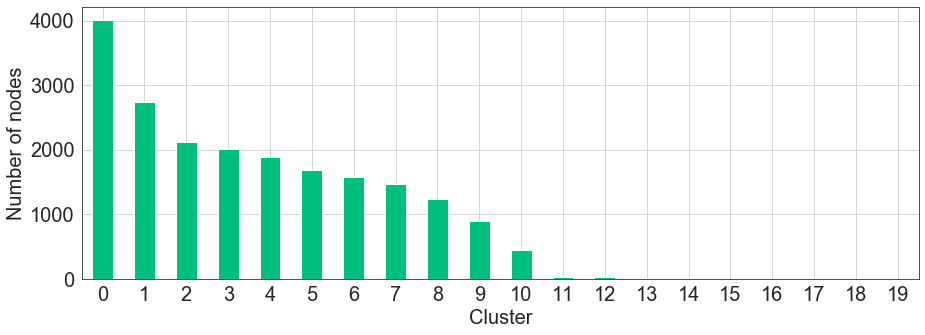

In [159]:
curr_type = 'Monocyte'
algo = 'leiden'
curr_data = 'data_all'

data_to = os.path.join(_DATA_HOME, 'cell_types', curr_type, 'data', 'grnboost2', f'{algo}_communities')

data_all = pd.read_pickle(os.path.join(data_to, f'raw_data_communities_info.pickle'))
data_C, data_M, data_S = [
    pd.read_pickle(os.path.join(data_to, f'raw_data_{pat}_type_communities_info.pickle')) for pat in ['C', 'M', 'S']
]

data_to_plot = eval(curr_data)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 5))
    data_to_plot['num_nodes'].plot(kind='bar', ax=ax, rot=0, color=colors['saturated_green'])
    plt.xlabel('Cluster', fontsize=20)
    plt.ylabel('Number of nodes', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.grid(True)
    plt.savefig(f'tmp/tmp_{curr_type}_cluster_node_count.pdf', bbox_inches='tight')

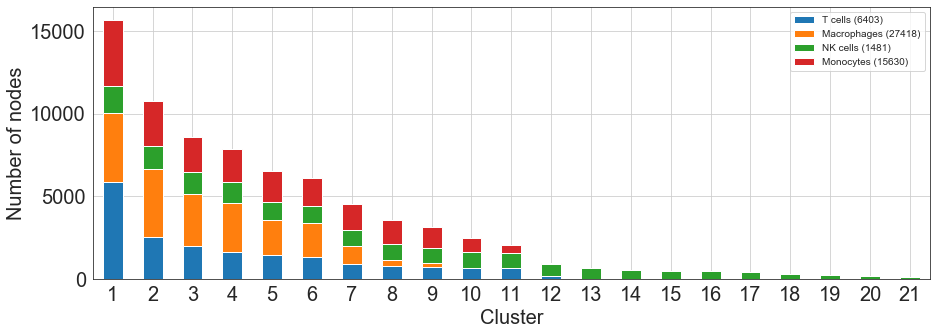

In [86]:
def get_num_cells(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return int(curr_meta[col_key].sum())
    else:
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return int(full_meta.loc[pat, col_key])
    
cell_types = ['T_cells', 'Macrophage', 'NK_cell', 'Monocyte']
titles = dict(zip(
    cell_types,
    [f'T cells ({get_num_cells("all_data", "T_cells")})', f'Macrophages ({get_num_cells("all_data", "Macrophage")})', 
     f'NK cells ({get_num_cells("all_data", "NK_cell")})', f'Monocytes ({get_num_cells("all_data", "Monocyte")})']
))
algo = 'leiden'
curr_data = 'data_all'

with sns.axes_style("white"):
    
    df = pd.concat([
        pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', curr_type, 'data', 'grnboost2', f'{algo}_communities', 'raw_data_communities_info.pickle'
        ))['num_nodes'].rename(curr_type) for curr_type in cell_types
    ], axis=1).fillna(0).rename(columns=titles).assign(new_index=range(1, 22)).set_index('new_index')
    
    f, ax = plt.subplots(figsize=(15, 5))
    
    df.plot(kind='bar', stacked=True, ax=ax, rot=0)
    
    plt.xlabel('Cluster', fontsize=20)
    plt.ylabel('Number of nodes', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.grid(True)
    plt.legend()
    plt.savefig(f'tmp/tmp_cluster_node_count.pdf', bbox_inches='tight')

In [74]:
from src.func import *
%autoreload 2
def resave_plot(data, data_type, plot_type, save_fig, save_fig_title):
    
    algo = 'leiden'
    limit_anno_until = 50
    G_size_to_plot = 2000
    seed = 42
        
    # Loading the gene functional annotation
    anno_db_tags = ['GO', 'KEGG', 'immunological', 'hallmark']
    gene_func_dbs = {tag: load_gene_func_db(tag, as_series=True) for tag in anno_db_tags}
    
    # Loading graph
    G = get_nx_graph(data=data, data_type='all', get_filtered=_Q_THRESH)
    print('Loaded the graph..')
    
    # Getting partitions
    if algo == 'louvain':
        partition = community_louvain.best_partition(G.to_undirected(), weight='importance', random_state=seed)
    elif algo == 'leiden':
        G_igraph = ig.Graph.from_networkx(G.to_undirected())
        la_partition = la.find_partition(G_igraph, la.ModularityVertexPartition, weights='importance', seed=seed)
        partition = {G_igraph.vs[node]['_nx_name']: i for i, cluster_nodes in enumerate(la_partition) for node in cluster_nodes}
    else:
        raise NotImplementedError
        
    print('Computed partition..')
        
    num_partitions = len(set(partition.values()))
    
    df = pd.read_pickle(
        os.path.join(_DATA_HOME, 'cell_types', data, 'data', 
                     'grnboost2', f'{algo}_communities', f'raw_data_communities_info.pickle')
    )

    if data_type == 'all':
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_communities_info.pickle'
        ))
    else:
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_{data_type}_type_communities_info.pickle'
        ))  
    print('Loaded pre-computed results..')
    
    # Getting positions of squeezed graph - we do not plot every gene on the figure
    squeezed_G, squeezed_partition = squeeze_graph(G, partition, approximate_size=G_size_to_plot)
    squeezed_pos = nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)

    # squeezed_pos = netgraph_community_layout(squeezed_G, squeezed_partition, seed=seed)  # nx.nx_agraph.pygraphviz_layout(G.to_undirected(), prog="sfdp")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)

    print('Started plotting..')
    f, ax = plt.subplots(figsize=(20, 20))

    nx.draw(squeezed_G, squeezed_pos, ax=ax, arrowstyle="->", arrowsize=20, 
            connectionstyle=f'arc3, rad = 0.25', edge_color='gray', width=0.4, 
            node_color='k', node_size=50, alpha=0.01)
    nx.draw_networkx_nodes(squeezed_G, squeezed_pos, ax=ax, node_size=100, 
                           nodelist=list(squeezed_partition.keys()), 
                           node_color='gray', 
                           alpha=0.1)

    ax.set_title(f'Found communities ({pat}, "all", {data}), '
                 f'annotation - {plot_type}', 
                 fontsize=30)
    plt.axis('off')
    print('Finished plotting..')

    if save_fig:
        plt.savefig(f'tmp/{save_fig_title}.pdf', bbox_inches='tight')
        
widget = interactive(
    resave_plot, 
    {'manual': True},
    data=['Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    data_type = ['all', 'C', 'M', 'S'],
    plot_type = ['genes', 'func_GO', 'func_KEGG', 'func_immunological', 'func_hallmark'],
    save_fig = [True, False],
    save_fig_title = 'tmp_wordcloud_example_1'
)
display(widget)

interactive(children=(Dropdown(description='data', options=('Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cel…